<a href="https://colab.research.google.com/github/arjan-hada/antibody-binding-affinity/blob/main/00_ml_antibody_bind_affinity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine learning guided binding affinity prediction from antibody libraries - 1

In this notebook, we aim to predict the binding affinity (Kd) between single-chain variable fragments (scFv) variants and the target peptide. This notebook is the first in a series showing every step of the process and is more on exploratory and explanatory side.

### Goals
- Conduct exploratory data analysis (EDA) to understand the dataset's characteristics.
- Develop a regression model to predict binding affinities.
- Compare the performance of different pretrained protein language models.

### Notebook Overview
1. **Exploratory Data Analysis (EDA)**: We will visualize distribution of numeric column, handle missing values, handle replicate measurements, and analyze the sequence data for mutations.
2. **Model Development**: Build and train a regression model using the pretrained AbLang-H model.
3. **Pretrained Model Evaluation**: Assess and compare the efficacy of several models including AbLang_heavy, antiberta2, antiberta2-cssp, and ESM2_t33_650M_UR50D on our dataset.


## Setup

In [1]:
# Setup block for Colab
# Install necessary libraries for the project
!pip install python-Levenshtein evaluate datasets transformers[torch] rjieba &> /dev/null
!apt install git-lfs &> /dev/null

In [2]:
# Import necessary libraries
from pathlib import Path
import os
from urllib.request import urlretrieve

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context="paper", font_scale=1.5)

import Levenshtein
from functools import partial

## The dataset

We will use a dataset that consists of binding interactions for antibodies against a SARS-CoV-2 peptide detailed in the study "[Machine learning optimization of candidate antibody yields highly diverse sub-nanomolar affinity antibody libraries](https://www.nature.com/articles/s41467-023-39022-2#data-availability)". The complete raw dataset was also published separately [here](https://www.nature.com/articles/s41597-022-01779-4) and available for public access at [Zenodo](https://zenodo.org/records/7783546).  The target peptide is a conserved sequence found in the HR2 region of coronavirus spike proteins and to which neutralizing antibodies were previously identified. The full data includes four different libraries of single-chain variable fragments (scFv). In this study we will only use the AA4L49 library for Ab-14 heavy chain sequences.

AB-14 Heavy chain sequence with CDRs highlighted in bold.

EVQLVETGGGLVQPGGSLRLSCAAS**GFTLNSYGIS**WVRQAPGKGPEWVSV**IYSDGRRTFYGDSV**KGRFTISRDTSTNTVYLQMNSLRVEDTAVYYCAK**GRAAGTFDS**WGQGTLVTVSS

In [3]:
target = 'PDVDLGDISGINAS' # a peptide in the HR2 region of the SARS-CoV-2 spike protein to which neutralizing antibodies have been observed.
wt_14VH = 'EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTISRDTSTNTVYLQMNSLRVEDTAVYYCAKGRAAGTFDSWGQGTLVTVSS'
wt_14VL = 'DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVAWYQQKAGQPPKLLIYWASTRESGV PDRFSGSGSGTDFTLTISSLQAEDAAVYYCQQYHRLPLSFGGGTKVEIK'

The data comes from two assays and three technical replicates. We will start by downloading the version of the data that has been corrected for both assay and replicate variations, as this corrected data was employed in the original study. Each assay has bias, as well as each replicate. Assay corrected data calculates a corrective term between the two assays and adds it against the second assay. Replicate corrected data calculates a corrected term between all assays (2) and replicates (3), leading to 5 corrective terms that are applied respectively to each assay/replicate combination.

In [4]:
# Setup Paths and URLs
urls = {
    'train': 'https://raw.githubusercontent.com/AIforGreatGood/biotransfer/main/example_data/covid/replicate_corrected/14H/14H_train.csv',
    'valid': 'https://raw.githubusercontent.com/AIforGreatGood/biotransfer/main/example_data/covid/replicate_corrected/14H/14H_valid.csv',
    'test': 'https://raw.githubusercontent.com/AIforGreatGood/biotransfer/main/example_data/covid/replicate_corrected/14H/14H_test.csv'
}

path_data = Path('data')
path_data.mkdir(exist_ok=True)
paths = {key: path_data / f'14H_{key}.csv' for key in urls}

In [5]:
def download_file(url, path):
    """Downloads and saves the file only if it does not already exist."""
    if not path.exists():
        urlretrieve(url, path)
        print(f"Downloaded {path}")
    else:
        print(f"File already exists at {path}")

def load_data(paths):
    """Load data from CSV files into Pandas DataFrames."""
    return {key: pd.read_csv(path) for key, path in paths.items()}

In [6]:
# Download and Load Data

for key, url in urls.items():
    download_file(url, paths[key])

df_dict = load_data(paths)

Downloaded data/14H_train.csv
Downloaded data/14H_valid.csv
Downloaded data/14H_test.csv


In [7]:
# List current directory contents for verification
!ls -l data

total 10696
-rw-r--r-- 1 root root 1094486 May  3 23:32 14H_test.csv
-rw-r--r-- 1 root root 8754055 May  3 23:32 14H_train.csv
-rw-r--r-- 1 root root 1094897 May  3 23:32 14H_valid.csv


**Train set**

In [8]:
print("Training Dataset Preview:")
display(df_dict['train'].head())

print("Training Dataset Info:")
df_dict['train'].info()

print("Training Dataset Descriptive Statistics:")
display(df_dict['train'].describe())

Training Dataset Preview:


,mata_description,matalpha_description,pred_aff,sample_name,assay,random_seed,alpha,aa_seq
0,AAYL49_28,MIT_Target,2.525612,1,1,1,0.735617,NFTLQSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTIS...
1,AAYL49_188,MIT_Target,2.096276,1,1,1,0.735617,QFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTIS...
2,AAYL49_9696,MIT_Target,3.516203,1,1,1,0.735617,GFLLNSYGISWVRQAPGKGPEWVSVIYSDGRRDFYGDSVKGRFTIS...
3,AAYL49_23809,MIT_Target,0.829115,1,1,1,0.735617,GFTLNSYGISWVRQAPGKGPEWVSVIYADGRRTFYHDSVKGRFTIS...
4,AAYL49_3791,MIT_Target,2.655010,1,1,1,0.735617,GFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVQGRFTIS...


Training Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63489 entries, 0 to 63488
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mata_description      63489 non-null  object 
 1   matalpha_description  63489 non-null  object 
 2   pred_aff              20547 non-null  float64
 3   sample_name           63489 non-null  int64  
 4   assay                 63489 non-null  int64  
 5   random_seed           63489 non-null  int64  
 6   alpha                 63489 non-null  float64
 7   aa_seq                63489 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 3.9+ MB
Training Dataset Descriptive Statistics:


,pred_aff,sample_name,assay,random_seed,alpha
count,20547.000000,63489.000000,63489.0,63489.0,63489.000000
mean,4.015680,2.000000,1.0,1.0,0.698276
std,1.442510,0.816503,0.0,0.0,0.026785
min,-0.004601,1.000000,1.0,1.0,0.674095
25%,2.892834,1.000000,1.0,1.0,0.674095
50%,4.166085,2.000000,1.0,1.0,0.685117
75%,5.080040,3.000000,1.0,1.0,0.735617
max,7.813413,3.000000,1.0,1.0,0.735617


| Variable Name | Description |
|----------|:--------|
| mata_description  | Alphanumeric label corresponding to amino acid sequence.   |
| matalpha_description    | Protein target represented by a text label for which the measured antibody interacted with.    |
| pred_aff | Value representing the score from the AlphaSeq assay. Values estimate the protein-protein dissociation constant in nanomolar, on a log scale. Lower values indicate stronger binding.   |  
| sample_name    | Unique replicate identifier, either 1, 2 or 3.     |
| assay  | Unique assay identifier, either 1 or 2.   |  
| aa_seq     | Single letter amino acid representation of scFv measured.     |

**Valid set**

In [9]:
print("Valid Dataset Preview:")
display(df_dict['valid'].head())

print("Valid Dataset Info:")
df_dict['valid'].info()

print("Valid Dataset Descriptive Statistics:")
display(df_dict['valid'].describe())

Valid Dataset Preview:


,mata_description,matalpha_description,pred_aff,sample_name,assay,random_seed,alpha,aa_seq
0,AAYL49_29259,MIT_Target,1.069632,1,1,1,0.735617,GETLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTIS...
1,AAYL49_29557,MIT_Target,1.714164,1,1,1,0.735617,GFTLNSYGISWVRQAPGKGPEWVSVIYSDGVRTFYGDSVKGRFTIS...
2,AAYL49_430,MIT_Target,2.970897,1,1,1,0.735617,GSTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTIS...
3,AAYL49_3965,MIT_Target,1.994197,1,1,1,0.735617,GFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTIS...
4,AAYL49_23646,MIT_Target,3.814387,1,1,1,0.735617,GFTLNSYGISWVRQAPGKGPEWVSVIYHDGRRQFYGDSVKGRFTIS...


Valid Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7935 entries, 0 to 7934
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mata_description      7935 non-null   object 
 1   matalpha_description  7935 non-null   object 
 2   pred_aff              2606 non-null   float64
 3   sample_name           7935 non-null   int64  
 4   assay                 7935 non-null   int64  
 5   random_seed           7935 non-null   int64  
 6   alpha                 7935 non-null   float64
 7   aa_seq                7935 non-null   object 
dtypes: float64(2), int64(3), object(3)
memory usage: 496.1+ KB
Valid Dataset Descriptive Statistics:


,pred_aff,sample_name,assay,random_seed,alpha
count,2606.000000,7935.000000,7935.0,7935.0,7935.000000
mean,3.988409,2.000000,1.0,1.0,0.698276
std,1.470628,0.816548,0.0,0.0,0.026786
min,0.551845,1.000000,1.0,1.0,0.674095
25%,2.850582,1.000000,1.0,1.0,0.674095
50%,4.155362,2.000000,1.0,1.0,0.685117
75%,5.054349,3.000000,1.0,1.0,0.735617
max,7.648367,3.000000,1.0,1.0,0.735617


**Test set**

In [10]:
print("Test Dataset Preview:")
display(df_dict['test'].head())

print("Test Dataset Info:")
df_dict['test'].info()

print("Test Dataset Descriptive Statistics:")
display(df_dict['test'].describe())

Test Dataset Preview:


,mata_description,matalpha_description,pred_aff,sample_name,assay,random_seed,alpha,aa_seq
0,AAYL49_29258,MIT_Target,1.279977,1,1,1,0.735617,GDTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTIS...
1,AAYL49_9600,MIT_Target,2.372003,1,1,1,0.735617,GFDLNSYGISWVRQAPGKGPEWVSVIYSDGRHHFYGDSVKGRFTIS...
2,AAYL49_686,MIT_Target,1.130628,1,1,1,0.735617,GFTINEYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTIS...
3,AAYL49_3528,MIT_Target,2.831809,1,1,1,0.735617,GFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYQDSVKGRFTIS...
4,AAYL49_3793,MIT_Target,2.104664,1,1,1,0.735617,GFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVVGRFTIS...


Test Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7938 entries, 0 to 7937
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mata_description      7938 non-null   object 
 1   matalpha_description  7938 non-null   object 
 2   pred_aff              2576 non-null   float64
 3   sample_name           7938 non-null   int64  
 4   assay                 7938 non-null   int64  
 5   random_seed           7938 non-null   int64  
 6   alpha                 7938 non-null   float64
 7   aa_seq                7938 non-null   object 
dtypes: float64(2), int64(3), object(3)
memory usage: 496.2+ KB
Test Dataset Descriptive Statistics:


,pred_aff,sample_name,assay,random_seed,alpha
count,2576.000000,7938.000000,7938.0,7938.0,7938.000000
mean,3.989569,2.000000,1.0,1.0,0.698276
std,1.425527,0.816548,0.0,0.0,0.026786
min,0.293907,1.000000,1.0,1.0,0.674095
25%,2.853725,1.000000,1.0,1.0,0.674095
50%,4.161495,2.000000,1.0,1.0,0.685117
75%,5.019098,3.000000,1.0,1.0,0.735617
max,7.784024,3.000000,1.0,1.0,0.735617


## EDA

In this section, we will explore train, valid, and test datasets. Our objectives are to understand the data's underlying distribution, handle missing or infinite values, handle replicate measurements, identify non-standard amino acids, and prepare the data for subsequent modeling stages.

### Explore columns

In [11]:
df_dict['train'].columns

Index(['mata_description', 'matalpha_description', 'pred_aff', 'sample_name',
       'assay', 'random_seed', 'alpha', 'aa_seq'],
      dtype='object')

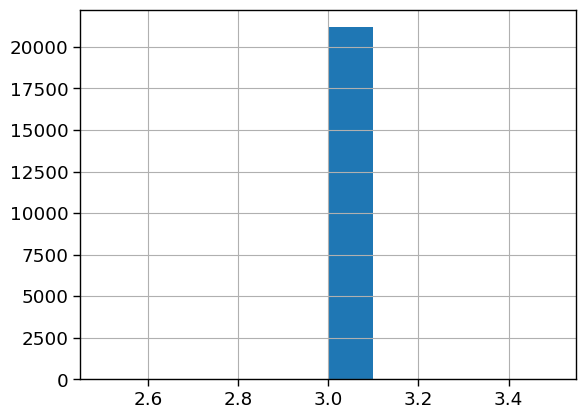

In [12]:
df_dict['train'].value_counts('mata_description').hist();

In [13]:
df_dict['train'].value_counts('matalpha_description')

matalpha_description
MIT_Target    63489
Name: count, dtype: int64

In [14]:
df_dict['train'].value_counts('sample_name')

sample_name
1    21163
2    21163
3    21163
Name: count, dtype: int64

These are three replicate measurements. So each sequence has three measurements reflecting technical variation.

In [15]:
df_dict['train'].value_counts('assay')

assay
1    63489
Name: count, dtype: int64

All the samples come from same assay with identifier 1.

In [16]:
df_dict['train'].value_counts('alpha')

alpha
0.674095    21163
0.685117    21163
0.735617    21163
Name: count, dtype: int64

There are three alpha values one for each replicate.

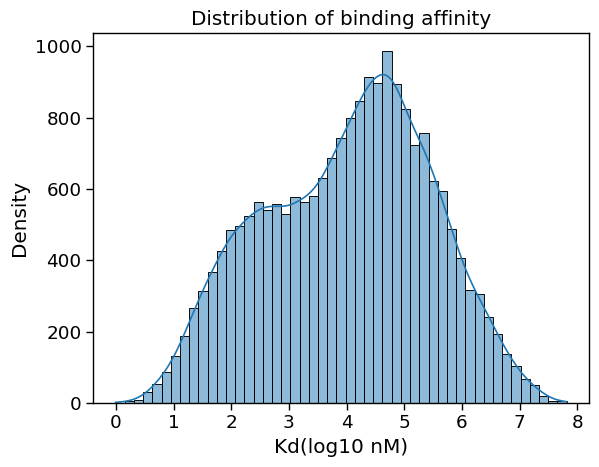

In [17]:
sns.histplot(df_dict['train']['pred_aff'].values, kde=True)
plt.xlabel('Kd(log10 nM)')
plt.ylabel('Density')
plt.title("Distribution of binding affinity");

That's the distribution of binding affinity for all three replicates combined. Let's look at each replicate binding affinity data separately.

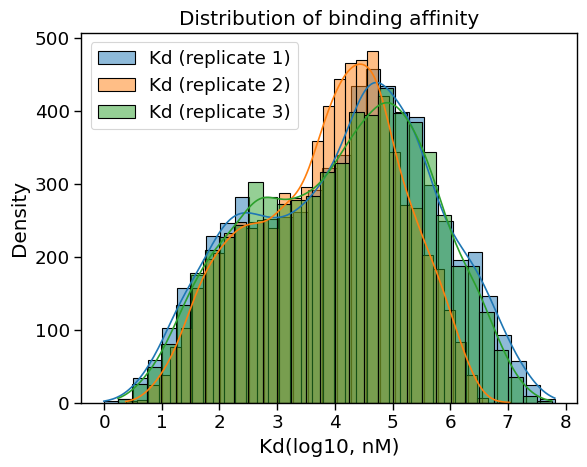

In [18]:
sns.histplot(df_dict['train']['pred_aff'][df_dict['train']['sample_name'] ==1].values,
             label = "Kd (replicate 1)", kde=True)
sns.histplot(df_dict['train']['pred_aff'][df_dict['train']['sample_name'] ==2].values,
             label = "Kd (replicate 2)", kde=True)
sns.histplot(df_dict['train']['pred_aff'][df_dict['train']['sample_name'] ==3].values,
             label = "Kd (replicate 3)", kde=True)
plt.legend()
plt.xlabel('Kd(log10, nM)')
plt.ylabel('Density')
plt.title("Distribution of binding affinity");

Let's also check how good is the correlation between three replicates with a scatterplot.

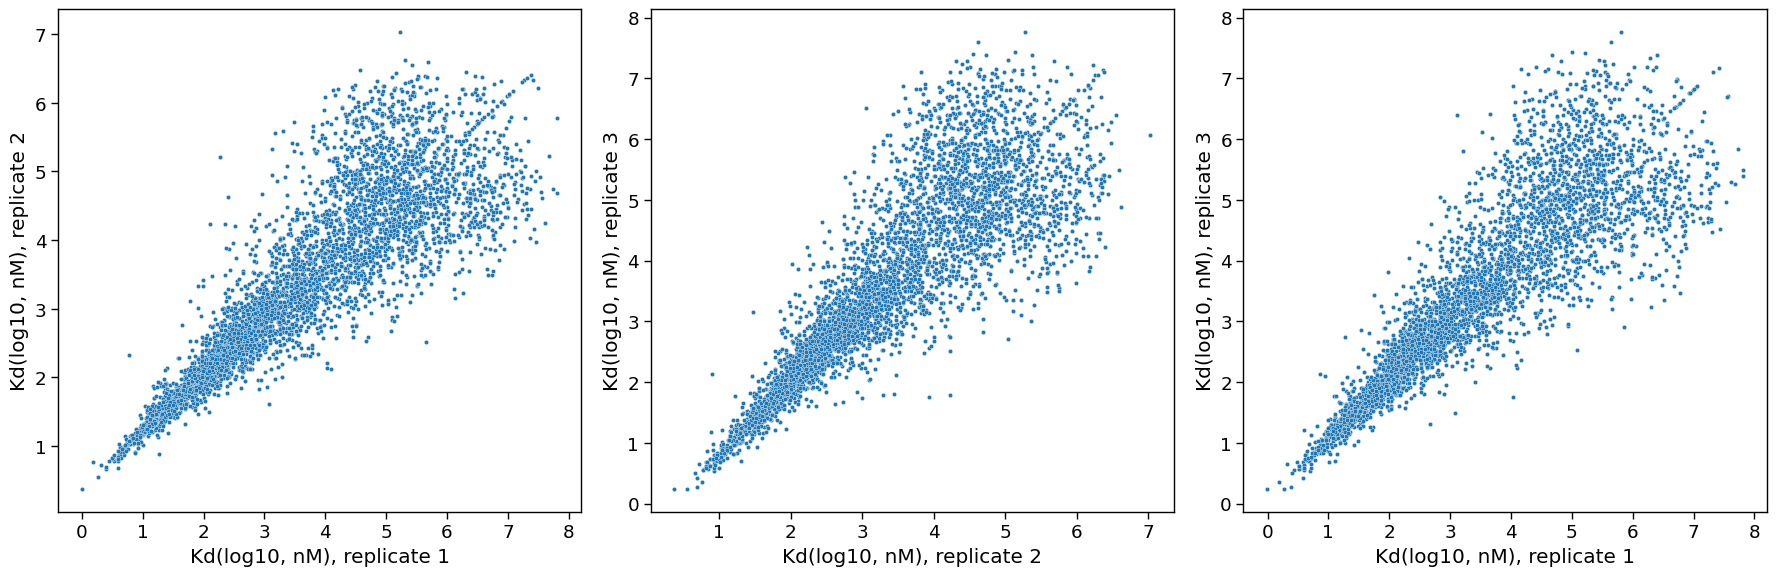

In [19]:
df_train_wide = df_dict['train'][['mata_description', 'pred_aff', 'sample_name']].pivot_table(
    index='mata_description', columns='sample_name',values='pred_aff')


plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(data=df_train_wide, x=1, y=2, s=10)
plt.xlabel('Kd(log10, nM), replicate 1')
plt.ylabel('Kd(log10, nM), replicate 2')

plt.subplot(1, 3, 2)
sns.scatterplot(data=df_train_wide, x=2, y=3, s=10)
plt.xlabel('Kd(log10, nM), replicate 2')
plt.ylabel('Kd(log10, nM), replicate 3')

plt.subplot(1, 3, 3)
sns.scatterplot(data=df_train_wide, x=1, y=3, s=10)
plt.xlabel('Kd(log10, nM), replicate 1')
plt.ylabel('Kd(log10, nM), replicate 3')

plt.tight_layout()
plt.show()

The binding measurements are provided on a log-scale, with lower values indicating stronger binding. Higher Kd values reflect lower binding affinity, more noise in measurement and hence higher variability as the Kd increases.

Finally let's plot the distribution of binding affinity for train, valid, and test set.

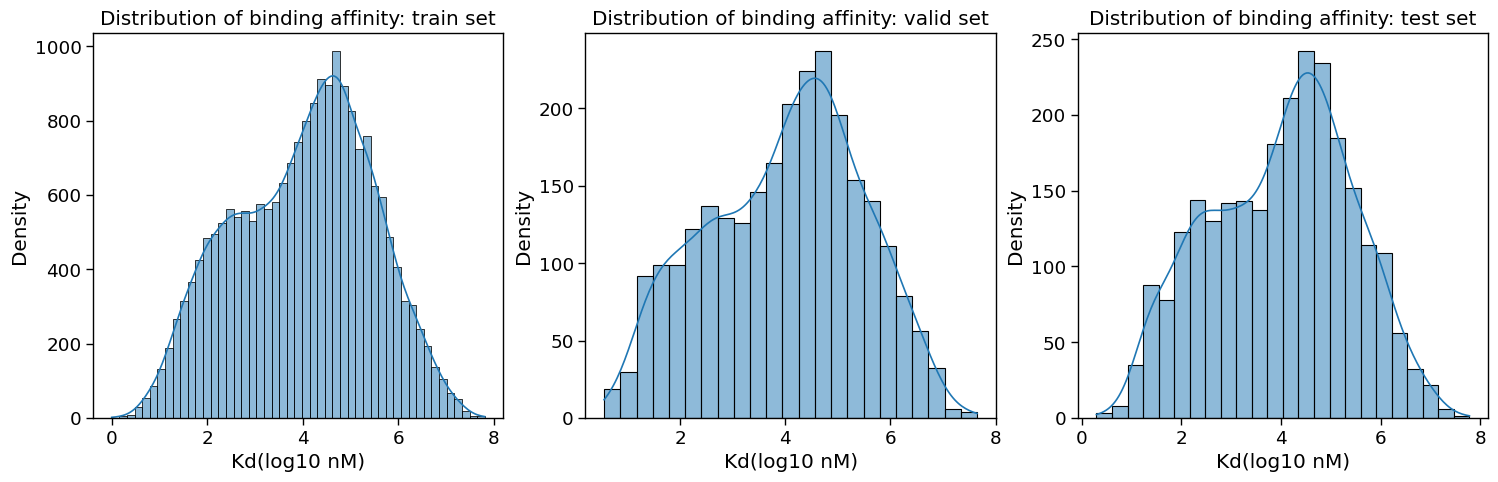

In [20]:
# Set up the matplotlib figure
plt.figure(figsize=(18, 5))

for i, (key, df) in enumerate(df_dict.items()):
    # First scatter plot:
    plt.subplot(1, len(df_dict.items()), i+1)
    sns.histplot(df['pred_aff'].values, kde=True)
    plt.xlabel('Kd(log10 nM)')
    plt.ylabel('Density')
    plt.title(f"Distribution of binding affinity: {key} set");

### Handling Infinite Values

In [21]:
# Function to check for infinite values in a DataFrame
def check_inf(df, df_name):
    # Identify numerical columns in the DataFrame
    num_cols = df.select_dtypes(include=[np.number])  # This filters for columns that contain numerical data

    # Check for infinite values only in these numerical columns
    has_inf = np.isinf(num_cols).any().any()  # Using any().any() to check the entire DataFrame slice

    print(f"{df_name} contains infinite values: {has_inf}")
    return has_inf

In [22]:
for key, df in df_dict.items():
    print(check_inf(df, key))

train contains infinite values: False
False
valid contains infinite values: False
False
test contains infinite values: False
False


### Handling Missing Values and replicate measurements

Since there are three technical replicates for each sequence, we need to check and make sure that replicates are not spread out across train, valid, and test set. This will help us determine appropriate strategy for handling missing values.

In [23]:
set1 = set(df_dict['train']['mata_description'])
set2 = set(df_dict['valid']['mata_description'])
set3 = set(df_dict['test']['mata_description'])

common_entries = set1.intersection(set2).intersection(set3)

common_entries = set1 & set2 & set3

common_entries

set()

Let's check for missing values in train, valid, and test dataframe.

In [24]:
def plot_nan_vs_nonan(df, column_name, title):
    """
    Plots the count of NaN and non-NaN entries for a specified column on a given axis.
    """

    nan_count = df[column_name].isna().sum()
    non_nan_count = df[column_name].notna().sum()

    counts = [nan_count, non_nan_count]
    labels = ['NaN', 'Non-NaN']

    plt.bar(labels, counts, color=['red', 'green'])
    plt.title(f'{title}')
    plt.ylabel('Count')

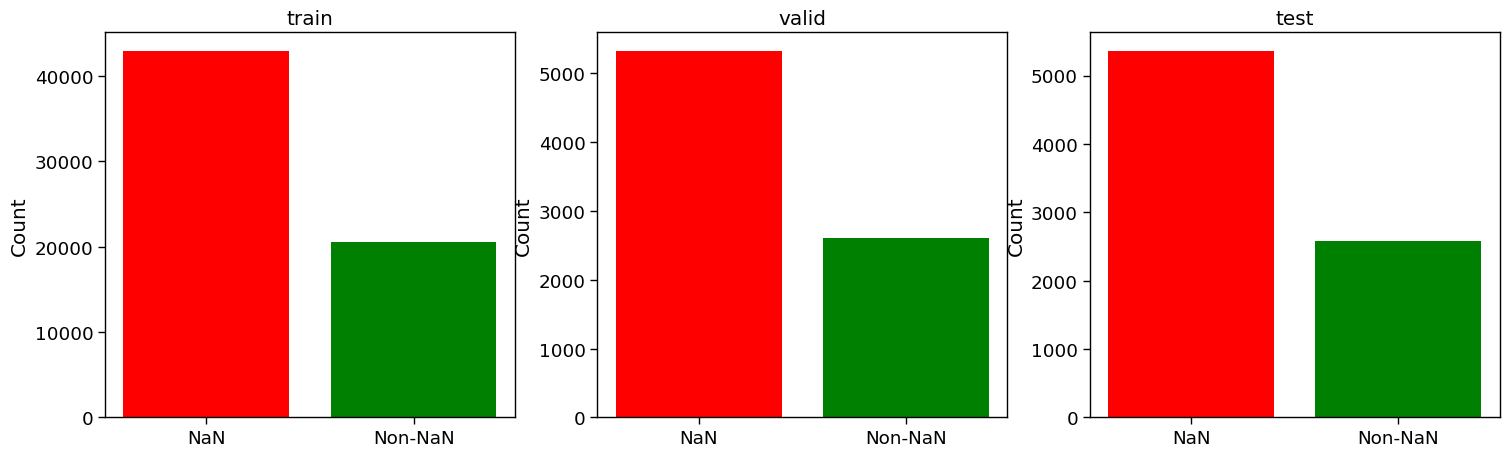

In [25]:
# Set up the matplotlib figure
plt.figure(figsize=(18, 5))

for i, (key, df) in enumerate(df_dict.items()):
    # First scatter plot:
    plt.subplot(1, len(df_dict.items()), i+1)
    plot_nan_vs_nonan(df, 'pred_aff', key)

There are a lot more NaN compared to not NaN.

Data entries with missing Kd values indicates that it is beyond the limit of detection and is deemed a poor binder. The [original study](https://www.nature.com/articles/s41467-023-39022-2) used two options for treating missing values: dropping the assay with missing value or imputing it with the median value. An ensemble model was then developed using both approaches.

In [26]:
def handle_missing_values(dfs, group_col='mata_description', target_col='pred_aff', filter_nan='drop'):
    """
    Handles missing values in a dictionary of DataFrames by either dropping them or filling them
    with the median of groups with less than 3 non-NaN entries. It processes 'train', 'valid',
    and 'test' datasets as provided in the dictionary 'dfs'.

    Parameters:
        dfs (dict): Dictionary containing the dataframes under keys 'train', 'valid', 'test'.
        group_col (str): The column to group by.
        target_col (str): The column for which the median is calculated.
        filter_nan (str): The method to handle NaN values ('drop' or 'median').
    """
    data_all = pd.concat(dfs.values())

    # Exclude groups where all rows contained NaN in target_col
    dfs['test'] = dfs['test'].groupby(group_col).filter(lambda x: x[target_col].notna().sum() > 0)

    if filter_nan == 'drop':
        for key, df in dfs.items():
            dfs[key] = df.dropna(subset=[target_col])
    elif filter_nan == 'median':
        # Drop NaN values and calculate medians for groups with less than 3 non-NaN entries.
        non_nan_data = data_all.dropna(subset=[target_col])
        medians = non_nan_data.groupby(group_col).filter(lambda x: len(x) < 3)[target_col].median()

        for key, df in dfs.items():
            dfs[key][target_col] = df[target_col].fillna(medians)

    return dfs

The experimental assay on the initial random scFv library was conducted in triplicate (each scFv sequence has 3 measurements). Like in the original study, we will use the average value of all measurements corresponding to the same scFv.

In [27]:
def process_replicates(dataframes, group_col='mata_description', target_col='pred_aff'):
    """Calculate mean of replicates and drop duplicates."""
    for df in dataframes.values():
        df[target_col] = df.groupby(group_col)[target_col].transform('mean')
        df.drop_duplicates(subset=[group_col], inplace=True)

We will now examine the effects of both dropping and imputing missing values on the data.

#### Impute with median and aggregate replicates

Specifically, the original study used median values from a subset of data with less than 3 entries (reflecting poor binders) to fill in NaNs in the entire train, valid, and test datasets.

In [28]:
import copy
# Create deep copies of the DataFrames
dfs_copies1 = {key: df.copy() for key, df in df_dict.items()}

handle_missing_values(dfs_copies1, filter_nan='median')
process_replicates(dfs_copies1)

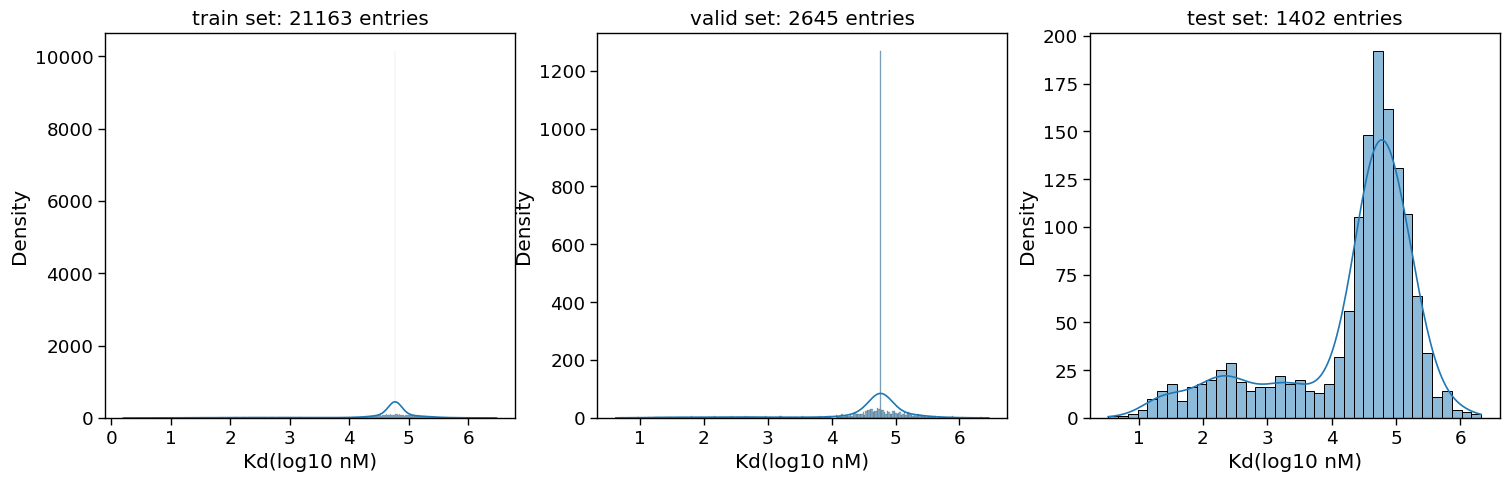

In [29]:
# Set up the matplotlib figure
plt.figure(figsize=(18, 5))

for i, (key, df) in enumerate(dfs_copies1.items()):
    # First scatter plot:
    plt.subplot(1, len(dfs_copies1.items()), i+1)
    sns.histplot(df['pred_aff'].values, kde=True)
    plt.xlabel('Kd(log10 nM)')
    plt.ylabel('Density')
    plt.title(f"{key} set: {df.shape[0]} entries");

Since the NaN entries dominate train, valid, and test set, imputing here with median is not a good idea.

#### Drop NA and aggregate replicates

In [30]:
import copy
# Create deep copies of the DataFrames
dfs_copies2 = {key: df.copy() for key, df in df_dict.items()}

handle_missing_values(dfs_copies2, filter_nan='drop')
process_replicates(dfs_copies2)

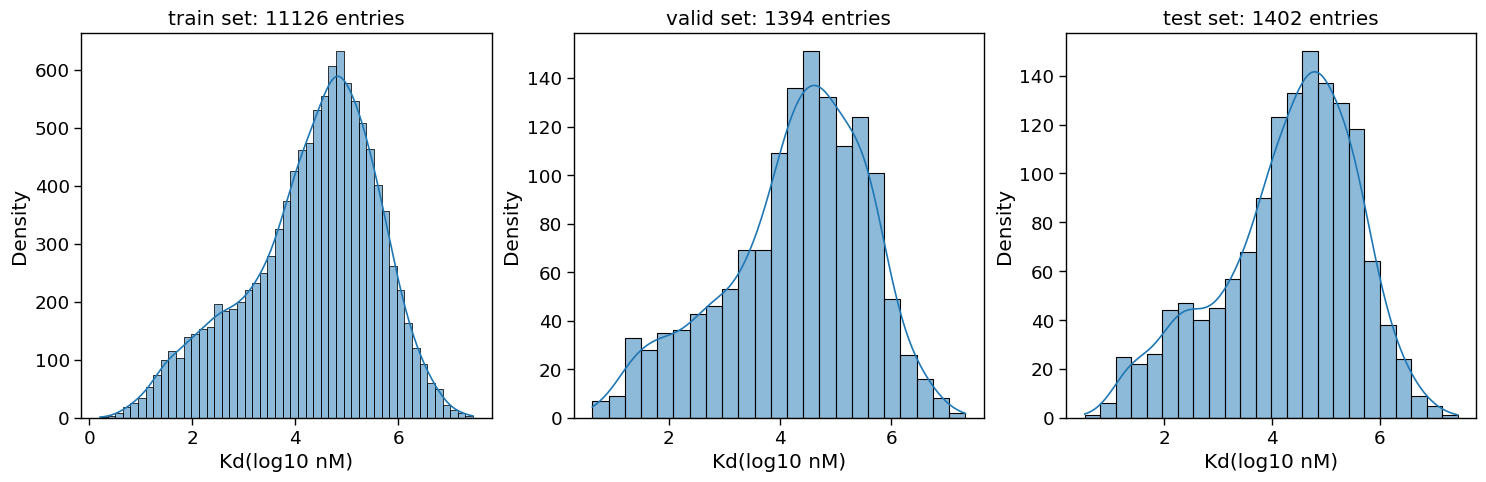

In [31]:
# Set up the matplotlib figure
plt.figure(figsize=(18, 5))

for i, (key, df) in enumerate(dfs_copies2.items()):
    # First scatter plot:
    plt.subplot(1, len(dfs_copies2.items()), i+1)
    sns.histplot(df['pred_aff'].values, kde=True)
    plt.xlabel('Kd(log10 nM)')
    plt.ylabel('Density')
    plt.title(f"{key} set: {df.shape[0]} entries");

The distribution of binding affinity (Kd) values in train, valid, and test sets after dropping NaN values are now much more balanced across all three datasets.

### Look for non-standard aminoacid

Identify any non-standard amino acids in the sequences which may affect model training.

In [32]:
# Set of standard amino acids
std_aa = {'A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'}

# Function to find non-standard amino acids
def is_nonstd_aa(seq):
    nonstd_aa = set(seq) - std_aa
    return True if nonstd_aa else False

In [33]:
for key, df in dfs_copies2.items():
    print(df[df['aa_seq'].apply(is_nonstd_aa)])

Empty DataFrame
Columns: [mata_description, matalpha_description, pred_aff, sample_name, assay, random_seed, alpha, aa_seq]
Index: []
Empty DataFrame
Columns: [mata_description, matalpha_description, pred_aff, sample_name, assay, random_seed, alpha, aa_seq]
Index: []
Empty DataFrame
Columns: [mata_description, matalpha_description, pred_aff, sample_name, assay, random_seed, alpha, aa_seq]
Index: []


### Feature Engineering

**Sequence length distribution of scFv heavy chain variant.**

In [34]:
for key, df in dfs_copies2.items():
    df['seq_len'] = df['aa_seq'].apply(len)
    print(f'len of `aa_seq` in {key} set')
    print(df.value_counts('seq_len'))
    print("\n")

len of `aa_seq` in train set
seq_len
82    11126
Name: count, dtype: int64


len of `aa_seq` in valid set
seq_len
82    1394
Name: count, dtype: int64


len of `aa_seq` in test set
seq_len
82    1402
Name: count, dtype: int64




The aminoacid sequence in all three datasets are the same length.

Let us look at the wildtype heavy chain sequence.

In [35]:
print(wt_14VH)
print(len(wt_14VH))

EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTISRDTSTNTVYLQMNSLRVEDTAVYYCAKGRAAGTFDSWGQGTLVTVSS
118


Looks like aminoacid sequences within the data are missing static sequences on the beginning and end from the original sequence.

In [36]:
mutation_window = 'GFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTISRDTSTNTVYLQMNSLRVEDTAVYYCAKGRAAGTFDS'
len(mutation_window)

82

In [37]:
static_left = 'EVQLVETGGGLVQPGGSLRLSCAAS'
static_right = 'WGQGTLVTVSS'

In [38]:
len(static_left + mutation_window + static_right) == len(wt_14VH)

True

In [39]:
def add_static_sequences(dataframes, aa_col='aa_seq', left_seq='', right_seq=''):
    """Add static sequences to amino acid sequences."""
    for df in dataframes.values():
        df['hc'] = left_seq + df[aa_col].astype(str) + right_seq

In [40]:
add_static_sequences(dfs_copies2, left_seq='EVQLVETGGGLVQPGGSLRLSCAAS', right_seq='WGQGTLVTVSS')

**How many mutations are there in scFv variant?**

In [41]:
for key, df in dfs_copies2.items():
    df['num_muts'] = df['hc'].apply(lambda x:
                                    len(Levenshtein.editops(wt_14VH, x)))
    print(f'number of mutations in in {key} set')
    print(df.value_counts('num_muts'))
    print("\n")

number of mutations in in train set
num_muts
3    9079
2    1692
1     354
0       1
Name: count, dtype: int64


number of mutations in in valid set
num_muts
3    1144
2     205
1      45
Name: count, dtype: int64


number of mutations in in test set
num_muts
3    1110
2     243
1      49
Name: count, dtype: int64




## Training preparation

In [ ]:
# Add space inbetween aminoacids. Some tokenizers require this
for key, df in dfs_copies2.items():
    df['inputs'] = df['hc'].apply(lambda x: ' '.join(x))

### Imports

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer

import datasets
from datasets import load_dataset, Dataset, DatasetDict

import gc # Python's garbage collection module

In [ ]:
# HuggingFace Transformers spits out lots of warnings, so let's quieten it down
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

### Defining the performance metrics

In [ ]:
from evaluate import load
import numpy as np

metric_spearmanr = load("spearmanr")

def compute_metrics(eval_pred):
    """
    Compute Spearman's rank correlation coefficient between the predicted and
    actual labels
    """
    predictions, labels = eval_pred
    return metric_spearmanr.compute(predictions=predictions, references=labels)

## Building our first model

### Tokenizing the data

We use the pretrained tokenizer from AbLang-H model to convert sequences into a format suitable for the model.

In [ ]:
model_ckpt = 'qilowoq/AbLang_heavy'

In [ ]:
tokz = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/71.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.02k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
# rename the pred_aff column to what Transformers expects for the dependent variable,
# which is labels

dds = {}
for key, df in dfs_copies2.items():
    ds = Dataset.from_pandas(df).rename_column('pred_aff', 'labels')
    dds[key] = ds

dds = DatasetDict(dds)

In [ ]:
def tok_func(x):
    return tokz(x["inputs"], return_tensors='pt')

In [ ]:
tok_func(dds['train'][0])

{'input_ids': tensor([[ 0,  6, 15, 10, 20, 15,  6,  8, 12, 12, 12, 20, 15, 10, 13, 12, 12,  7,
         20,  2, 20,  7, 11, 14, 14,  7,  9, 17,  8, 20, 10,  7, 18, 12, 16,  7,
         19, 15,  2, 10, 14, 13, 12,  4, 12, 13,  6, 19, 15,  7, 15, 16, 18,  7,
          5, 12,  2,  2,  8, 17, 18, 12,  5,  7, 15,  4, 12,  2, 17,  8, 16,  7,
          2,  5,  8,  7,  8,  9,  8, 15, 18, 20, 10,  1,  9,  7, 20,  2, 15,  6,
          5,  8, 14, 15, 18, 18, 11, 14,  4, 12,  2, 14, 14, 12,  8, 17,  5,  7,
         19, 12, 10, 12,  8, 20, 15,  8, 15,  7,  7, 22]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mas

In [ ]:
fields = list(dds['train'].column_names)
fields.remove('labels') # list containing the columns we no longer need

# Apply the tokenizer across the dataset in a batched manner
tok_dds = dds.map(tok_func, batched=True, remove_columns=fields)

Map:   0%|          | 0/11126 [00:00<?, ? examples/s]

Map:   0%|          | 0/1394 [00:00<?, ? examples/s]

Map:   0%|          | 0/1402 [00:00<?, ? examples/s]

In [ ]:
print(tok_dds['train'][0])

{'labels': 2.647404195335101, 'input_ids': [0, 6, 15, 10, 20, 15, 6, 8, 12, 12, 12, 20, 15, 10, 13, 12, 12, 7, 20, 2, 20, 7, 11, 14, 14, 7, 9, 17, 8, 20, 10, 7, 18, 12, 16, 7, 19, 15, 2, 10, 14, 13, 12, 4, 12, 13, 6, 19, 15, 7, 15, 16, 18, 7, 5, 12, 2, 2, 8, 17, 18, 12, 5, 7, 15, 4, 12, 2, 17, 8, 16, 7, 2, 5, 8, 7, 8, 9, 8, 15, 18, 20, 10, 1, 9, 7, 20, 2, 15, 6, 5, 8, 14, 15, 18, 18, 11, 14, 4, 12, 2, 14, 14, 12, 8, 17, 5, 7, 19, 12, 10, 12, 8, 20, 15, 8, 15, 7, 7, 22], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
tok_dds

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11126
    })
    valid: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1394
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1402
    })
})

In [ ]:
len(tok_dds['train'][0]['input_ids']) # adds special token at the beginning and end

120

In [ ]:
len(wt_14VH)

118

### Loading a pretrained model

Loading and configuring the model for sequence classification.

In [ ]:
gc.collect() # explicitly triggers garbage collection, free up memory
if torch.cuda.is_available(): torch.cuda.empty_cache() # clears the PyTorch CUDA memory cache

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                           num_labels=1,
                                                           trust_remote_code=True)

config.json:   0%|          | 0.00/848 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

### Fine-tuning the model

Setting up training arguments and starting the training process using Hugging Face's Trainer.

In [ ]:
torch.cuda.is_available() # check whether a GPU is available or not; use GPU

True

In [ ]:
lr,bs = 2e-5, 32
wd,epochs = 0.01,5

args = TrainingArguments('outputs', # Directory to save model outputs and checkpoints
                         learning_rate=lr,
                         #fp16=True,
                         warmup_ratio=0.1, # Warmup can help stabilize the learning process
                         lr_scheduler_type="cosine", # Using cosine learning rate decay
                         evaluation_strategy="epoch",
                         save_strategy = "epoch",
                         per_device_train_batch_size=bs,
                         per_device_eval_batch_size=2*bs, # Often set higher than training batch size if memory allows
                         num_train_epochs=epochs,
                         weight_decay=wd,
                         load_best_model_at_end=True)

In [ ]:
# Initialize Trainer
trainer = Trainer(
    model,
    args,
    train_dataset=tok_dds['train'],
    eval_dataset=tok_dds['valid'],
    tokenizer=tokz,
    compute_metrics=compute_metrics,
)

In [ ]:
# Start training
trainer.train();

Epoch,Training Loss,Validation Loss,Spearmanr
1,No log,2.133331,-0.115055
2,2.366600,1.738905,-0.079996
3,1.647000,1.690255,-0.052478
4,1.647000,1.687371,-0.018815
5,1.642200,1.701822,-0.016045


## Improving the model

### Tokenizer, Dataset, Trainer

For quicker iteration we will create some functions to try different pretrained models and trainer parameters.

In [ ]:
def tok_func(example, tokenizer, inp_col):
    """
    Tokenizes input data using a predefined tokenizer.
    `Dataset.map` needs this function.
    """
    # a dictionary containing 'input_ids' and other tensors like 'attention_mask'
    return tokenizer(example[inp_col], return_tensors='pt')

In [ ]:
def get_tok_dds(df_dict, tokenizer, inp_col, label_col):
    """
    Converts a dictionary of pandas DataFrames to a Hugging Face DatasetDict
    and tokenizes it.
    """

    # convert pandas DataFrames into HuggingFace Datasets
    # rename the labels column to what Transformers expects for the dependent variable, which is labels
    dds = {}
    for key, df in df_dict.items():
        ds = Dataset.from_pandas(df).rename_column(label_col, 'labels')
        dds[key] = ds

    dds = DatasetDict(dds)

    fields = list(dds['train'].column_names)
    fields.remove('labels') # list containing the columns we no longer need

    # tokenize the input, use batching to speed it up, and remove the columns we no longer need
    tok_dds = dds.map(lambda x: tok_func(x, tokenizer, inp_col),
                      batched=True,
                      remove_columns=fields)
    return tok_dds

In [ ]:
def get_trainer(tok_dds, model, tokenizer, output_dir='outputs',
                lr=2e-5, bs=32, epochs=5, wd=0.01):
    """
    Returns a Hugging Face Trainer instance with specified training arguments and datasets.
    """
    args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=lr,
        per_device_train_batch_size=bs,
        per_device_eval_batch_size=bs * 2,
        num_train_epochs=epochs,
        weight_decay=wd,
        fp16=True, # much faster on modern GPUs and saves some memory
        warmup_ratio=0.1,
        lr_scheduler_type="cosine", # cosine scheduler with warmup
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model='spearmanr',
        greater_is_better=True,
    )
    return Trainer(model, args, train_dataset=tok_dds['train'],
                   eval_dataset=tok_dds['valid'], tokenizer=tokenizer,
                   compute_metrics=compute_metrics)

In [ ]:
import gc # Python's garbage collection module

def clear_memory():
    gc.collect() # explicitly triggers garbage collection, free up memory
    if torch.cuda.is_available(): torch.cuda.empty_cache() # clears the PyTorch CUDA memory cache

### PALM: alchemab/antiberta2-cssp

In [ ]:
clear_memory()

model_ckpt = 'alchemab/antiberta2-cssp'
tokz = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                           num_labels=1)

tok_dds = get_tok_dds(dfs_copies2, tokz, inp_col='inputs', label_col='pred_aff')

tokenizer_config.json:   0%|          | 0.00/94.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/806M [00:00<?, ?B/s]

Map:   0%|          | 0/11126 [00:00<?, ? examples/s]

Map:   0%|          | 0/1394 [00:00<?, ? examples/s]

Map:   0%|          | 0/1402 [00:00<?, ? examples/s]

In [ ]:
get_trainer(tok_dds, model, tokz,
            lr=2e-5, bs=32, epochs=5, wd=0.01).train()

Epoch,Training Loss,Validation Loss,Spearmanr
1,No log,1.710336,0.462865
2,2.219700,1.614891,0.504929
3,1.155800,1.348642,0.508511
4,1.155800,1.095598,0.521767
5,0.975500,1.269830,0.524959


TrainOutput(global_step=1740, training_loss=1.3776756900480425, metrics={'train_runtime': 225.2261, 'train_samples_per_second': 246.996, 'train_steps_per_second': 7.726, 'total_flos': 8114549224975200.0, 'train_loss': 1.3776756900480425, 'epoch': 5.0})

### PALM: alchemab/antiberta2

In [ ]:
clear_memory()

model_ckpt = 'alchemab/antiberta2'
tokz = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                           num_labels=1)

tok_dds = get_tok_dds(dfs_copies2, tokz, inp_col='inputs', label_col='pred_aff')

Map:   0%|          | 0/11126 [00:00<?, ? examples/s]

Map:   0%|          | 0/1394 [00:00<?, ? examples/s]

Map:   0%|          | 0/1402 [00:00<?, ? examples/s]

In [ ]:
get_trainer(tok_dds, model, tokz,
            lr=2e-5, bs=32, epochs=5, wd=0.01).train()

Epoch,Training Loss,Validation Loss,Spearmanr
1,No log,1.225453,0.465924
2,2.299900,1.245085,0.508681
3,1.085500,1.075479,0.516175
4,1.085500,1.031744,0.522661
5,0.940200,1.078008,0.521690


TrainOutput(global_step=1740, training_loss=1.3648874129372082, metrics={'train_runtime': 212.5164, 'train_samples_per_second': 261.768, 'train_steps_per_second': 8.188, 'total_flos': 8114549224975200.0, 'train_loss': 1.3648874129372082, 'epoch': 5.0})

### PPLM: facebook/esm2_t33_650M_UR50D

#### ESM2: epochs=5

In [ ]:
clear_memory()

model_ckpt = 'facebook/esm2_t33_650M_UR50D'
tokz = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                           num_labels=1)

tok_dds = get_tok_dds(dfs_copies2, tokz, inp_col='hc', label_col='pred_aff')

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

Map:   0%|          | 0/11126 [00:00<?, ? examples/s]

Map:   0%|          | 0/1394 [00:00<?, ? examples/s]

Map:   0%|          | 0/1402 [00:00<?, ? examples/s]

In [ ]:
get_trainer(tok_dds, model, tokz,
            lr=2e-5, bs=32, epochs=5, wd=0.01).train()

Epoch,Training Loss,Validation Loss,Spearmanr
1,No log,1.663283,0.447855
2,2.894100,1.053939,0.497999
3,1.076400,1.080098,0.524229
4,1.076400,0.995082,0.528298
5,0.972600,0.969788,0.527386


TrainOutput(global_step=1740, training_loss=1.5490374948786594, metrics={'train_runtime': 624.2922, 'train_samples_per_second': 89.109, 'train_steps_per_second': 2.787, 'total_flos': 2.60748816640272e+16, 'train_loss': 1.5490374948786594, 'epoch': 5.0})

#### ESM2: epochs=10

In [ ]:
clear_memory()

model_ckpt = 'facebook/esm2_t33_650M_UR50D'
tokz = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                           num_labels=1)

tok_dds = get_tok_dds(dfs_copies2, tokz, inp_col='hc', label_col='pred_aff')

Map:   0%|          | 0/11126 [00:00<?, ? examples/s]

Map:   0%|          | 0/1394 [00:00<?, ? examples/s]

Map:   0%|          | 0/1402 [00:00<?, ? examples/s]

In [ ]:
get_trainer(tok_dds, model, tokz,
            lr=2e-5, bs=32, epochs=10, wd=0.01).train()

Epoch,Training Loss,Validation Loss,Spearmanr
1,No log,1.181268,0.484828
2,3.281300,1.108306,0.495250
3,1.176100,1.302657,0.524016
4,1.176100,1.025911,0.520920
5,1.062300,1.006149,0.526597
6,0.972200,0.972774,0.533793
7,0.972200,0.965904,0.535274
8,0.898400,0.943764,0.525059
9,0.781200,0.978104,0.504989
10,0.781200,0.986995,0.501222


TrainOutput(global_step=3480, training_loss=1.2651290455083737, metrics={'train_runtime': 1248.5713, 'train_samples_per_second': 89.11, 'train_steps_per_second': 2.787, 'total_flos': 5.21497633280544e+16, 'train_loss': 1.2651290455083737, 'epoch': 10.0})

## Conclusion



**Performance Summary**

In our recent analysis, the **esm2_t33_650M_UR50D model** demonstrated superior performance compared to the other models evaluated, namely **antiberta2-cssp**, **antiberta2**, and **ablang-H**. Notably, while the performance of **ablang-H** lagged significantly behind, the remaining three models showed relatively comparable results. However, it is important to note the following distinctions:

- **Training Duration**: The **esm2_t33_650M_UR50D model** requires approximately three times longer to train than both **antiberta2-cssp** and **antiberta2** models.
- **Model Complexity**: The **esm2_t33_650M_UR50D** is substantially larger, containing about 650 million parameters, whereas both **antiberta2** and **antiberta2-cssp** have around 202 million parameters.

**Data Processing and Model Efficacy**

Following the data processing protocols from the original study, we managed to achieve comparable performance metrics. These protocols included:
- Dropping NA values or imputing them with the median of sequences where the affinity value was missing for one or two but not all three replicates.
- Aggregating replicates by taking the mean affinity value, as was done in the original study.

Remarkably, we reached a Spearman rho of 0.535 using just a single model, as opposed to the original study's ensemble of 16 models.

**Future Directions**

In the next phase of our research, we plan to explore alternative data processing strategies that deviate from those used in the original study. Our goal is to enhance the performance metrics of our model, aiming to surpass the Spearman rho achieved in the original study with just a single model.